In [1]:
import deeptrack as dt
from deeptrack.models.yolo import utils
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from simulation import *
from PIL import Image

c:\Users\santh\Desktop\Python Projects\Particle_Chamber\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\Users\santh\Desktop\Python Projects\Particle_Chamber\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


In [2]:
IMAGE_SIZE = 100
starting_value = dt.Value(lambda: np.ones((IMAGE_SIZE, IMAGE_SIZE)))

sim= starting_value >> MultiParticle(
    n_particles = lambda: int(np.random.rand()*10) + 35,
)

particle =  sim[0]
pos =  sim[1]
rad =  sim[2]






In [3]:
gradient = dt.IlluminationGradient(
    gradient=[.5e-3, 0e-3],#lambda: 1e-3 + np.random.randn(2) * 1e-3,
)

class Normalize(dt.Feature):
    def __init__(
        self, **kwargs
    ):
        super().__init__( **kwargs)

    def get(self, image, **kwargs):
        image = image / np.max(image)
        return image

class Rescale(dt.Feature):
    def __init__(
        self, **kwargs
    ):
        super().__init__( **kwargs)

    def get(self, image, **kwargs):
        image = image * np.ones(1)*256.0
        
        return image

rescaling = Rescale()
normalization = Normalize()
#transform = dt.ElasticTransformation(7, 3)
gauss = dt.Gaussian(mu = 0, sigma = .01)

import scipy
#Smoothing
#kernel = np.ones((5, 5, 1)) / np.random.normal(loc = 28, scale = 5, size =1)
smoothing = dt.Lambda(lambda: lambda image: scipy.ndimage.filters.convolve(image, np.ones((3, 3, 1)) / np.random.normal(loc = 10, scale = 1, size =1))) 

particle = particle >> smoothing >> rescaling # >> normalization# >> gauss >> transform


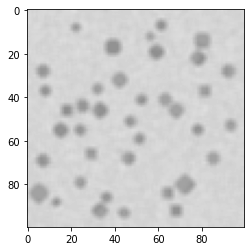

In [4]:
plt.imshow(np.reshape(particle.update().resolve(), (IMAGE_SIZE,IMAGE_SIZE)), cmap = "gray", vmin = 0, vmax = 256)
plt.show()


In [4]:

def get_label(rad, pos):
    rad = np.array(rad)
    rad = rad.astype(int)
    pos = np.array(pos)
    pos = pos.astype(int)    

    n = np.shape(rad)[0]  
    label = np.zeros((n, 5))
    top_left = np.zeros((n,2))
    bottom_right = np.zeros((n,2))
    top_left[:,0] = pos[:, 0]- 1.3*rad[:,0]
    top_left[:,1] = pos[:, 1]- 1.3*rad[:,0]
    bottom_right[:,0] = pos[:, 0]+ 1.3*rad[:,0]
    bottom_right[:,1] = pos[:, 1]+ 1.3*rad[:,0]

    for i in range ( n ):
        label[i, : ] = [top_left[i,0], top_left[i,1], bottom_right[i, 0], bottom_right[i,1], 0]
    
    #print(label)
    return label.astype(int)

In [5]:

label_func = particle >> dt.Lambda(lambda rad, pos: lambda x: get_label(rad, pos), rad=rad, pos=pos)
bboxes = label_func.resolve()


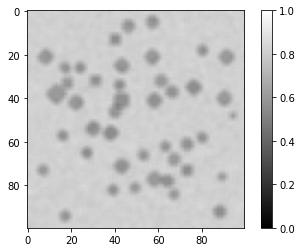

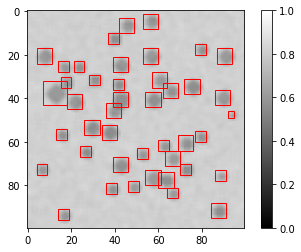

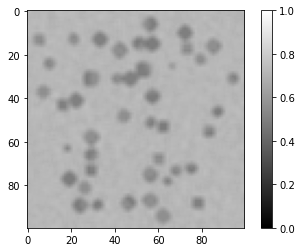

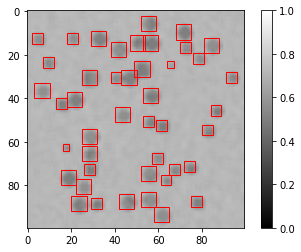

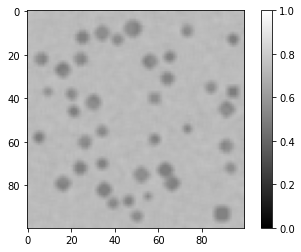

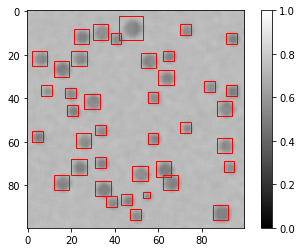

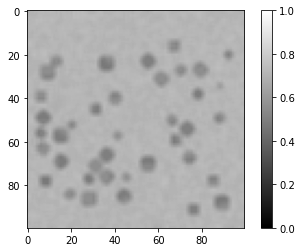

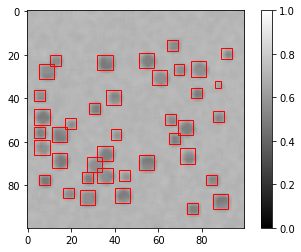

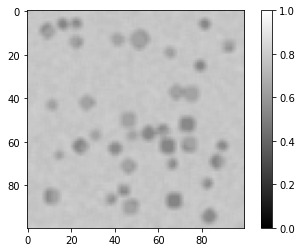

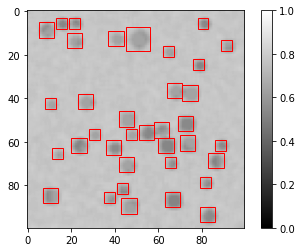

In [6]:
data = particle & label_func

NUMBER_OF_IMAGES = 5

for _ in range(NUMBER_OF_IMAGES):

    image_of_particle, bbox = data.update().resolve()
    bbox = np.array(bbox)

    image_of_particle = image_of_particle/256.0
    n = np.shape(bbox)[0]
    plt.imshow(np.reshape(image_of_particle,(100,100)), cmap="gray", vmin=0, vmax = 1)
    plt.colorbar()
    plt.show()
    plt.imshow(np.reshape(image_of_particle,(100,100)), cmap="gray", vmin=0, vmax = 1)
    plt.colorbar()
    ax = plt.gca()
    for i in range(int(n)):
        rect = plt.Rectangle(
            (
                bbox[i, 0],
                bbox[
                    i, 1
                ],
            ),
            bbox[i, 2] - bbox[i, 0],
            bbox[i, 3] - bbox[i, 1],
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    # plt.scatter(position_of_particles[:,0], position_of_particles[:,1], marker='+', edgecolors="r", linewidth=2)
    plt.show()
    histogram, bin_edges = np.histogram(np.reshape(image_of_particle,(100,100)), bins=256, range=(0, 1))

    # configure and draw the histogram figure
    """plt.figure()
    plt.title("Grayscale Histogram of simulation")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")
    plt.xlim([0.0, 1.0])  # <- named arguments do not work here

    plt.plot(bin_edges[0:-1], histogram)  # <- or here
    plt.show()"""

In [7]:
from tensorflow import keras

from deeptrack.models.yolo.yolo import YOLOv3

model = YOLOv3(
    (100, 100, 1),
    1,
    ANCHORS = [6, 8, 10, 12, 14, 16, 18, 20]
)

opt = keras.optimizers.Adam(learning_rate=0.0001)#learning_rate=0.0001

model.compile(optimizer=opt)#, loss_weights= [1, 1, 2]

In [8]:
from deeptrack.models.yolo.dataset import YoloDataGenerator

generator = YoloDataGenerator(
    feature=data,
    input_size=np.array([100]),
    num_class=1,
    label_function=lambda d: np.array(d[1]),
    batch_size=4,
    min_data_size=250,
    max_data_size=300,
)

generator.anchors = model.anchors

In [ ]:
with generator:
    model.fit(generator, epochs=50)

Generating 259 / 250 samples before starting training


/content/deeptrack/generators.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data), np.array(labels)


Epoch 1/50
64/64 [==============================] - 136s 2s/step - loss: 145.9140 - giou_loss: 93.6265 - conf_loss: 41.2365 - prob_loss: 11.0510
Epoch 2/50
64/64 [==============================] - 135s 2s/step - loss: 112.9443 - giou_loss: 81.0137 - conf_loss: 30.9306 - prob_loss: 1.0000
Epoch 3/50
64/64 [==============================] - 132s 2s/step - loss: 109.3210 - giou_loss: 78.5730 - conf_loss: 30.0444 - prob_loss: 0.7035
Epoch 4/50
64/64 [==============================] - 124s 2s/step - loss: 103.5217 - giou_loss: 74.3913 - conf_loss: 28.6849 - prob_loss: 0.4454
Epoch 5/50
64/64 [==============================] - 121s 2s/step - loss: 90.6187 - giou_loss: 67.9737 - conf_loss: 22.1985 - prob_loss: 0.4465
Epoch 6/50
64/64 [==============================] - 132s 2s/step - loss: 91.5880 - giou_loss: 70.8511 - conf_loss: 20.3647 - prob_loss: 0.3722
Epoch 7/50
64/64 [==============================] - 124s 2s/step - loss: 88.3606 - giou_loss: 69.7808 - conf_loss: 18.2427 - prob_loss: 0

In [ ]:
model.save("/content/drive/MyDrive/multi_particle4")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/multi_particle4/assets


In [9]:
model.load_weights("./multi_particle4")

In [20]:
from PIL import Image
no_of_frames = 100
overlapping_size = 20
IMAGE_SIZE = 100
exp_img_size = 2400
no_of_slides = int(exp_img_size/(IMAGE_SIZE-overlapping_size))
pos_all = []

im = []
pos_frame = []
for i in range(no_of_frames):
    
    if len(str(i)) == 1:
        file_name = '00'+str(i)+'.tif'
    elif len(str(i)) == 2:
        file_name = '0' + str(i)+'.tif'

    elif len(str(i)) == 3:
        file_name =  str(i)+'.tif'
    img = np.array(Image.open('C:/Users/santh/Desktop/Python Projects/Particle_Chamber/Videos/5fps/5fps'+file_name))[:,0:exp_img_size+20]
    im.append(img)
    pos_slide = [] 
    for j in range(no_of_slides):
        
        img_slide = np.expand_dims(img[:,j*(IMAGE_SIZE-overlapping_size):j*(IMAGE_SIZE-overlapping_size)+100],axis = 2)
        #print(np.shape(img_slide))
        img_slide = np.array(img_slide)/255
        
        img_slide = tf.convert_to_tensor(np.expand_dims(img_slide,axis = 0), dtype=tf.float32)
        y = model(img_slide)

        boxes = y[:, :, 0:4]
        pred_conf = y[:, :, 4:]

        boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
        scores=tf.reshape(pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
        max_output_size_per_class=50,
        max_total_size=50,
        iou_threshold=0.12,
        score_threshold=0.13,
        )

        #pred_bbox = [boxes.numpy()*IMAGE_SIZE, scores.numpy(), classes.numpy(), valid_detections.numpy()]
        pred_bbox = boxes.numpy()[0]*IMAGE_SIZE
        pos_slide.append(pred_bbox)
    pos_frame.append(pos_slide)

In [21]:
np.shape(pos_frame)

(100, 30, 50, 4)

In [22]:
pos_frame[0][0][0]

array([29.578955, 53.938198, 38.641254, 63.056038], dtype=float32)

In [23]:
# Changing to global Coordinate
frame_particles_in_globalCoord = []
for i in range(no_of_frames):
        
    slide_particles_global = []
    for j in range(no_of_slides):
        slide_pos_particles = pos_frame[i][j]
        slide_particles_global.append(slide_pos_particles)
        for k in range(np.shape(slide_pos_particles)[0]):
            
            slide_particles_global[j][k][1] = slide_particles_global[j][k][1]+j*(IMAGE_SIZE-overlapping_size)
            slide_particles_global[j][k][3] = slide_particles_global[j][k][3]+j*(IMAGE_SIZE-overlapping_size)

    frame_particles_in_globalCoord.append(slide_particles_global)

In [24]:
np.shape(frame_particles_in_globalCoord)

(100, 30, 50, 4)

In [25]:
def dist(pt1, pt2):
    d = np.sqrt(np.square(pt1[0]-pt2[0]) + np.square(pt1[1]-pt2[1]))
    return d

In [26]:
def area(bbox):
    area = np.abs((bbox[2]-bbox[0])*(bbox[3]-bbox[1]))
    return area

In [27]:
frames_particles_inGlobalCoord = []

for i in range(no_of_frames):
    global_frame_pos_particles = []
    for j in range(no_of_slides):
        for k in range(np.shape(frame_particles_in_globalCoord[i][j])[0]):
            pt1 = np.array([(frame_particles_in_globalCoord[i][j][k][1]+frame_particles_in_globalCoord[i][j][k][3])/2, (frame_particles_in_globalCoord[i][j][k][0]+frame_particles_in_globalCoord[i][j][k][2])/2])
            flag = 0
            if area(frame_particles_in_globalCoord[i][j][k])>=1:
                if j == 0:
                    global_frame_pos_particles.append(frame_particles_in_globalCoord[i][j][k])
                else:
                    for p in range(np.shape(frame_particles_in_globalCoord[i][j-1])[0]):
                        if area(frame_particles_in_globalCoord[i][j-1][p])>=1:
                            pt2 = np.array([(frame_particles_in_globalCoord[i][j-1][p][1]+frame_particles_in_globalCoord[i][j-1][p][3])/2, (frame_particles_in_globalCoord[i][j-1][p][0]+frame_particles_in_globalCoord[i][j-1][p][2])/2])
                            if dist(pt1,pt2) <=3:
                                flag = 1
                                break
                if flag == 0:
                    global_frame_pos_particles.append(frame_particles_in_globalCoord[i][j][k])
                                
    frames_particles_inGlobalCoord.append(np.array(global_frame_pos_particles))               



In [ ]:
for i in range(no_of_frames):
    centroid = [(frames_particles_inGlobalCoord[i][:,1]+frames_particles_inGlobalCoord[i][:,3])/2,(frames_particles_inGlobalCoord[i][:,0]+frames_particles_inGlobalCoord[i][:,2])/2]

    centroid = np.transpose(centroid)
    plt.figure(figsize=(100,10))
    plt.imshow(im[i], cmap = "gray", vmin = 0, vmax = 255)
    plt.colorbar()
    plt.scatter(centroid[:,0], centroid[:,1],s=10, c = "r")
    #plt.show()
    plt.savefig('./Outputs/Result images/{}.jpg'.format(i))


In [5]:
import cv2
import os
image_folder = './Outputs/Result images'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

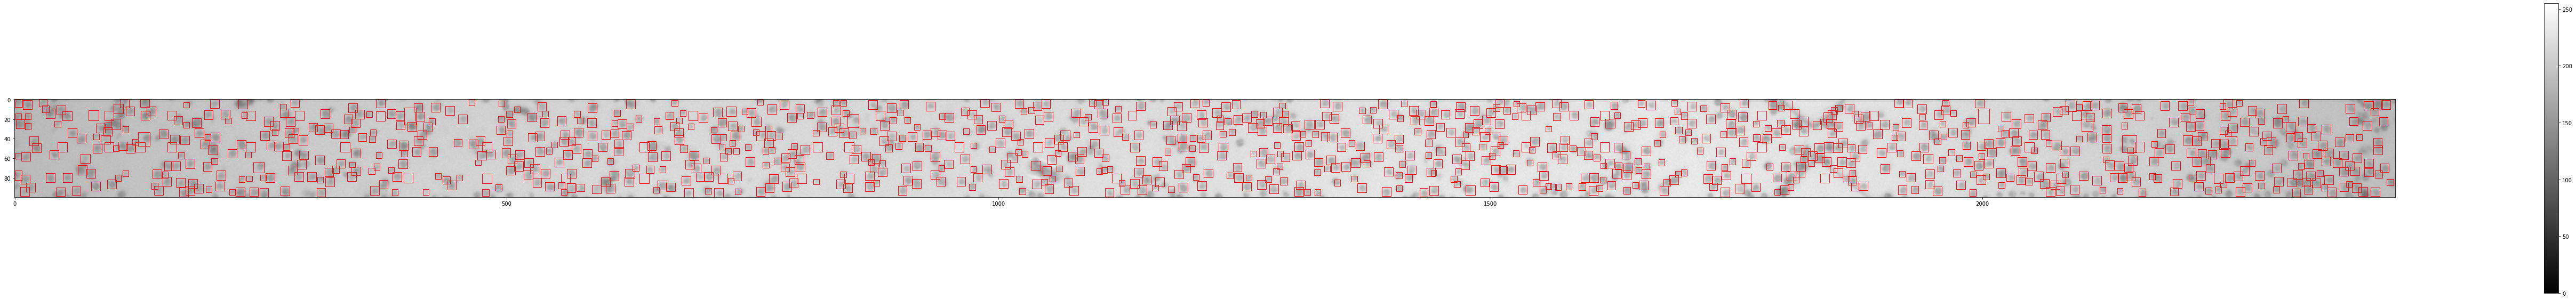

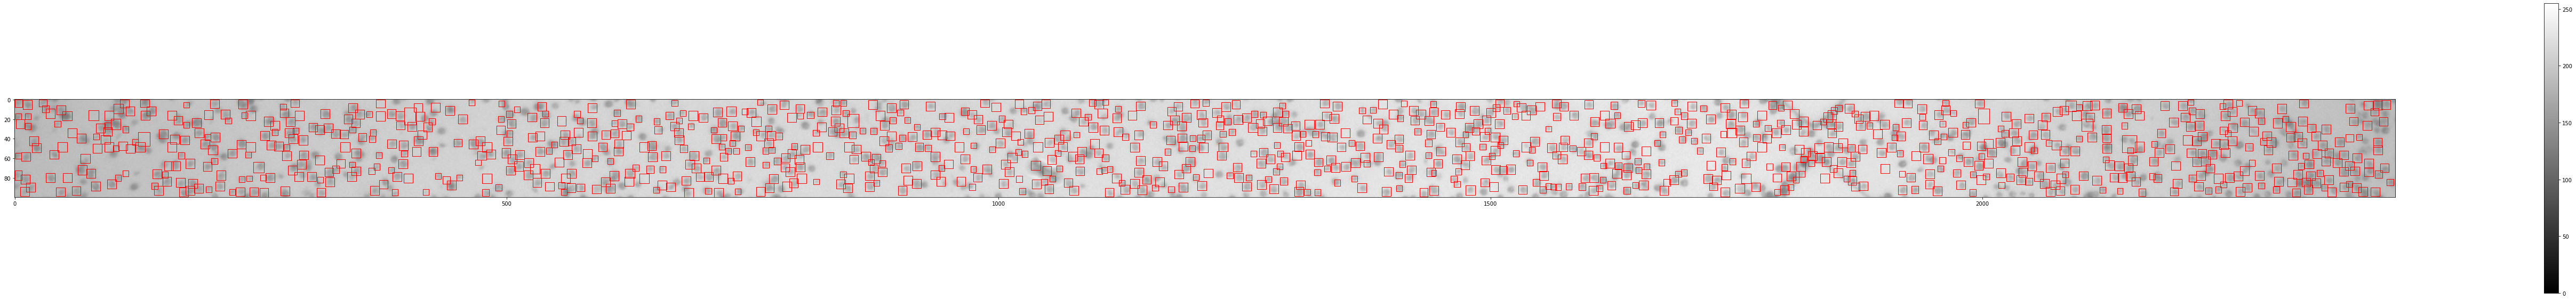

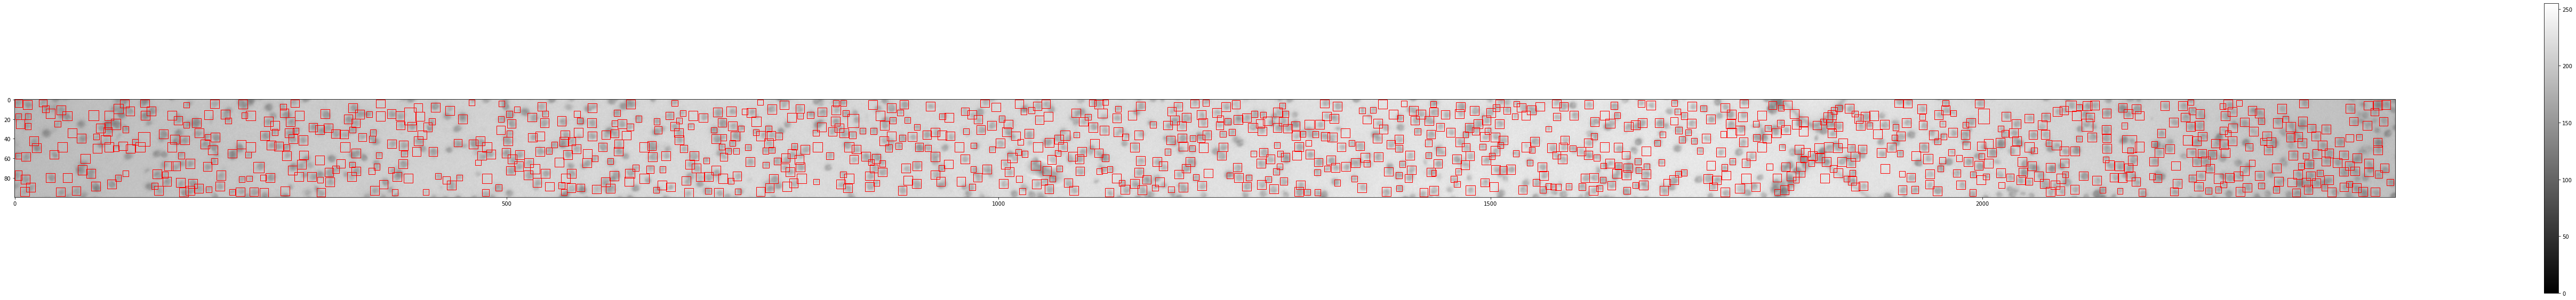

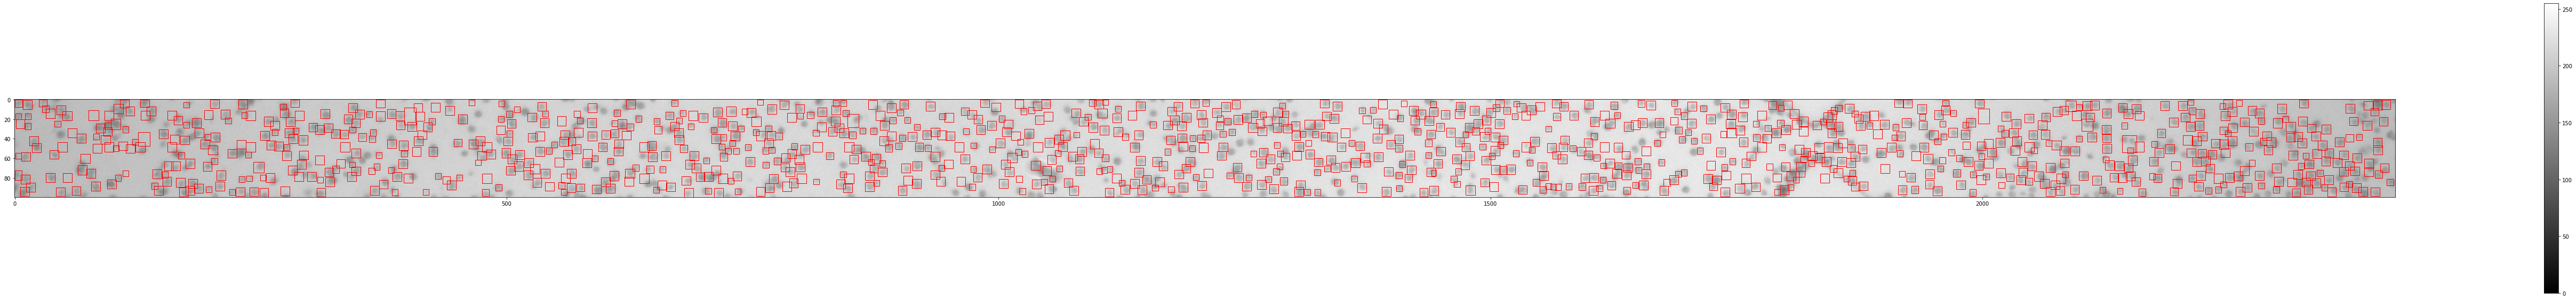

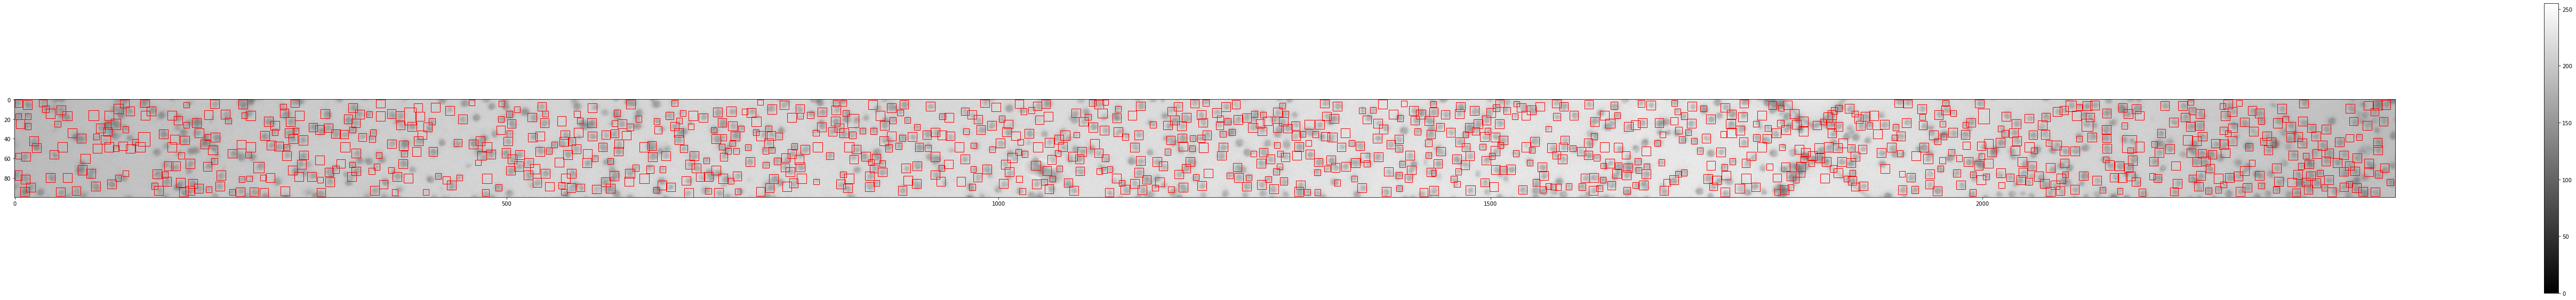

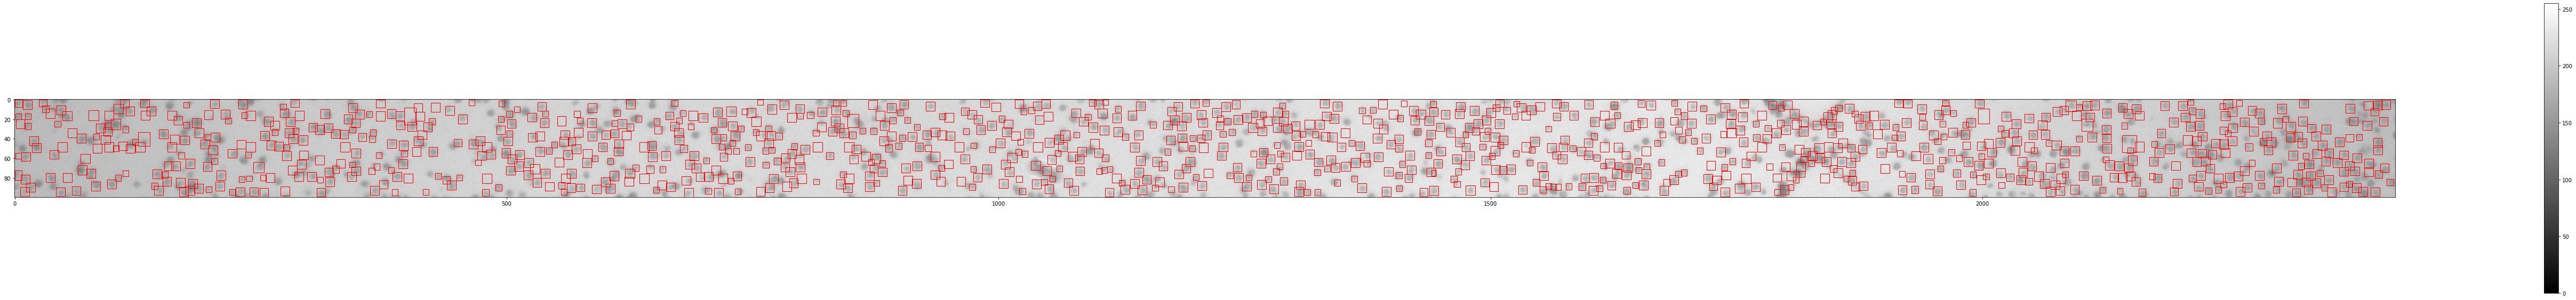

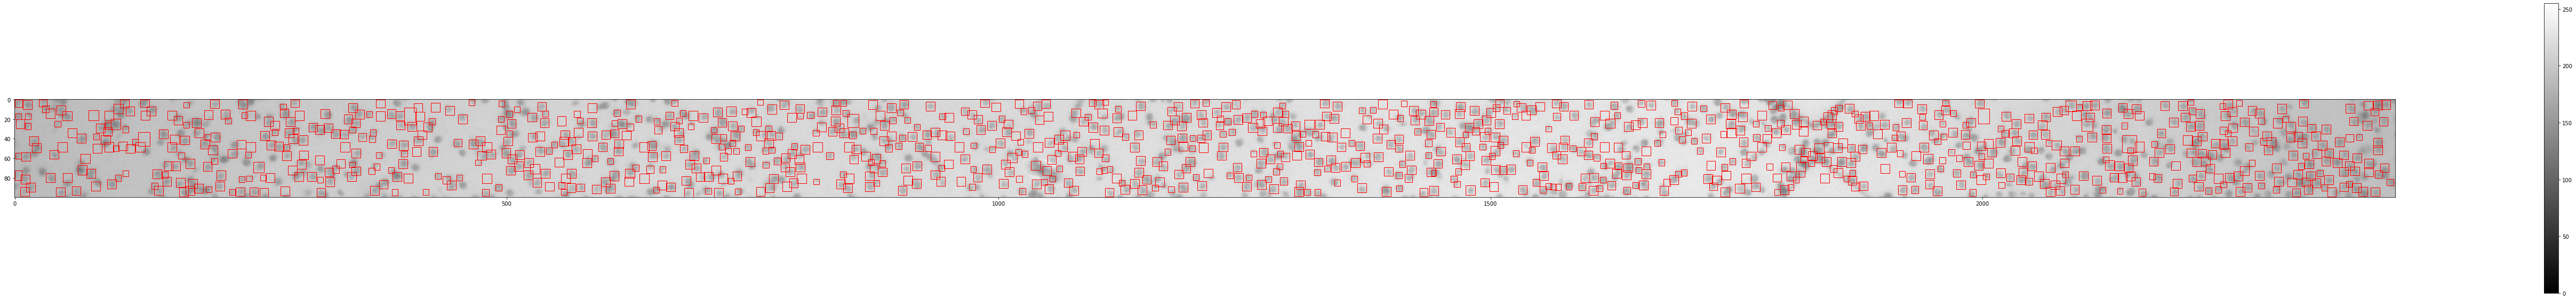

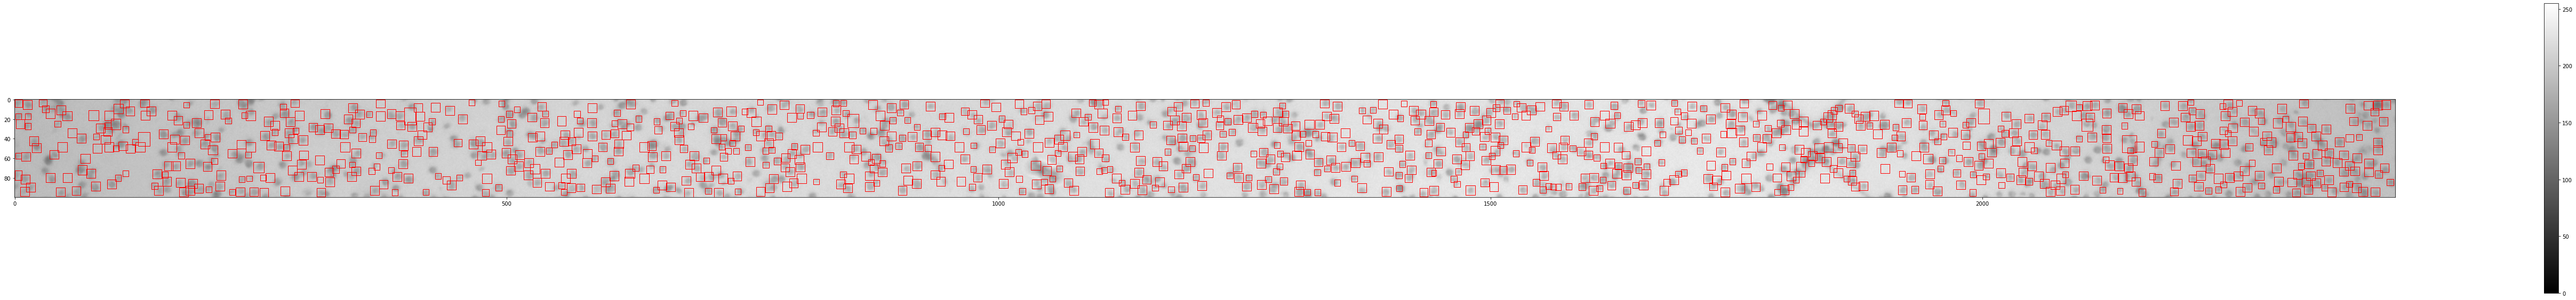

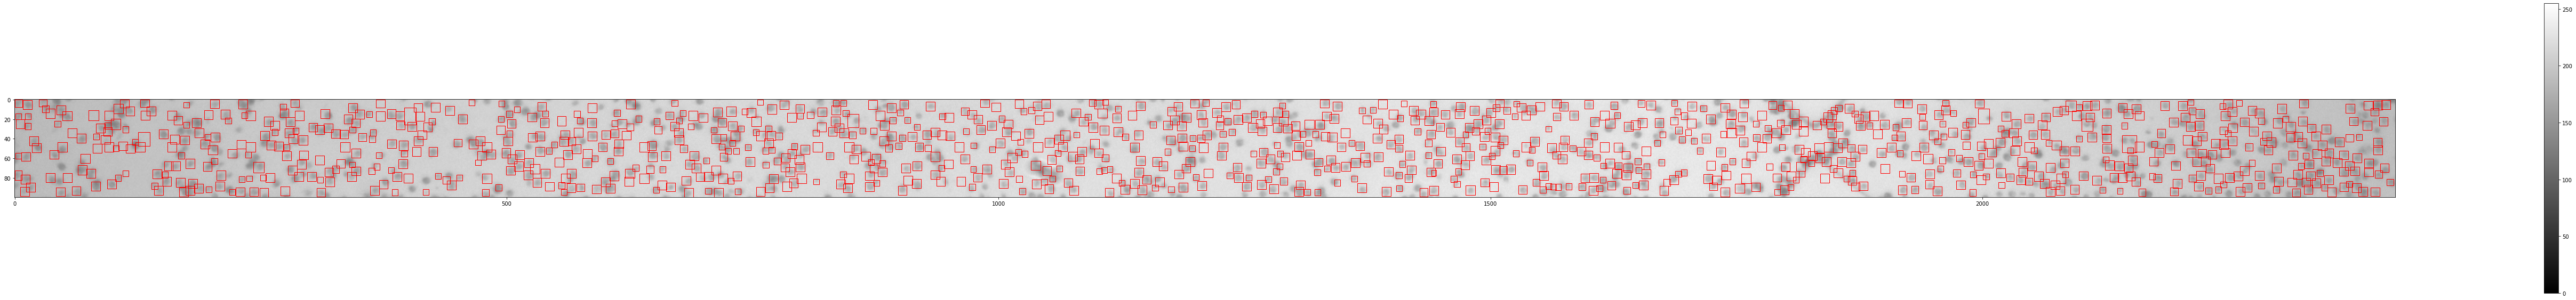

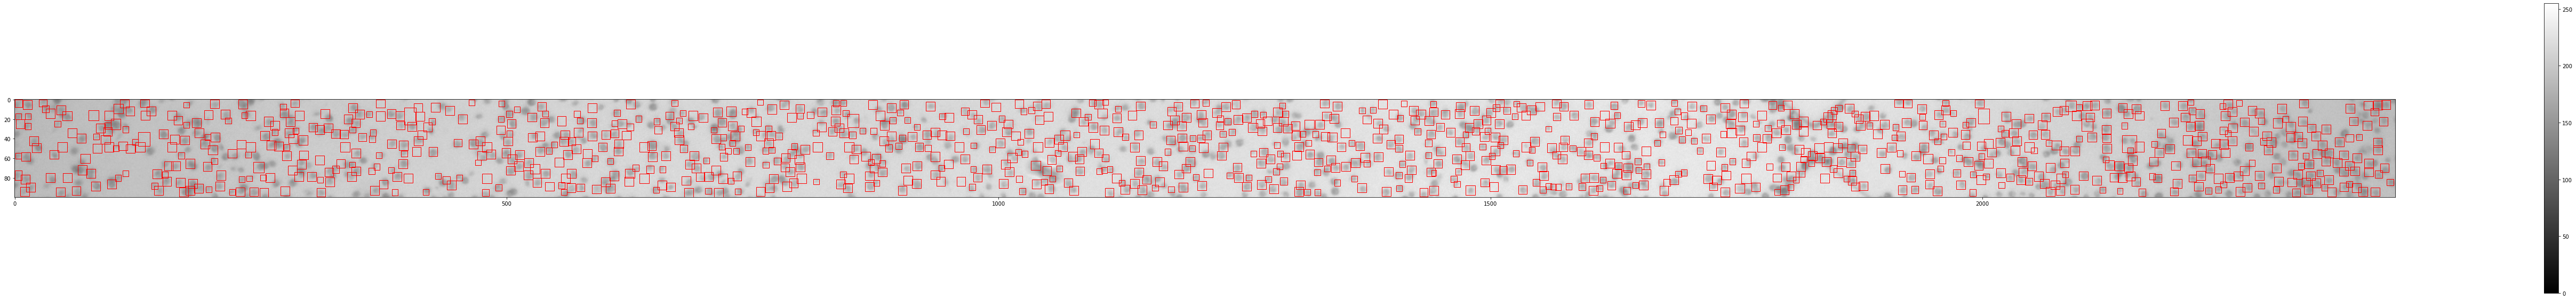

In [17]:
    
for i in range(no_of_frames):
    plt.figure(figsize=(100,10))
    plt.imshow(im[i], cmap="gray", vmin=0, vmax = 255)
    plt.colorbar()
    ax = plt.gca()
    for i in range(np.shape(frames_particles_inGlobalCoord[0])[0]):
        bbox = frames_particles_inGlobalCoord[0][i]
        rect = plt.Rectangle(
            (
                bbox[1],
                bbox[
                    0
                ],
            ),
            bbox[3] - bbox[1],
            bbox[2] - bbox[0],
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    # plt.scatter(position_of_particles[:,0], position_of_particles[:,1], marker='+', edgecolors="r", linewidth=2)
    plt.show()